In [6]:
from transformers import AutoModel, AutoTokenizer

model_name = "dbmdz/bert-base-italian-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModel.from_pretrained(model_name)

haspedee_dataset_path = 'data/haspeede2_dev_taskAB.tsv'

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"



/home/salvatore/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you

In [7]:
from random import sample
def balance_dataset(x,y_ref) -> tuple:
    number_of_0 = [value for value in y_ref if value == '0']
    number_of_1 = [value for value in y_ref if value != '0']

    elements_to_remove = abs(len(number_of_0) - len(number_of_1))

    indexes_no_hate_elements = []
    for i,elem in enumerate(y_ref):
        if elem == '0':
            indexes_no_hate_elements.append(i)
       
    indexes_element_to_remove = sample(population=indexes_no_hate_elements,k=elements_to_remove)

    x = x.drop(index=indexes_element_to_remove)
    y_ref = [y for i,y in enumerate(y_ref) if i not in indexes_element_to_remove]

    return x, y_ref

In [8]:
# Import and initializations
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

id_to_label = {"0":"NoHate", "1": "Hate"}
text_to_id_map = {}


def read_dataset(input_file):
  examples = []
  labels = []
  with open(input_file, 'r', encoding='utf-8', errors='ignore') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      random.shuffle(file_as_list)
      for line in file_as_list:
          if line.startswith("id"):
            continue
          split = line.split("\t")
          text = split[1]
          label = split[2]
          text_to_id_map[text] = split[0]
          labels.append(label)
          examples.append(text)
      f.close()
  return examples, labels


In [9]:

x, y_ref = read_dataset(haspedee_dataset_path)


# Pre processing

In [10]:
from keras.utils import pad_sequences
import torch
import emoji

def replace_substring_with_another_substring(text, substring_to_replace, substring_to_replace_with):
  return text.replace(substring_to_replace, substring_to_replace_with)

def is_token_length_compatible_with_bert(x):
  max_length = 512
  for elem in x:
    if len(elem) > max_length:
      return False
  return True

def token_with_max_length(x):
  max_length_token = 0
  for elem in x:
      if len(elem) > max_length_token:
        max_length_token = len(elem)
  return max_length_token

def create_attention_mask(input_id):
  attention_masks = []
  for sent in input_id:
    att_mask = [int(token_id > 0) for token_id in sent]  # create a list of 0 and 1.
    attention_masks.append(att_mask)  # basically attention_masks is a list of list
  return attention_masks

def handle_emoji(text):
  return emoji.replace_emoji(text,"")

# lowercase all the sentences
x = [x.lower() for x in x]
# delete @user and URL, because they are not useful for the classification task
x = list(map(lambda x: replace_substring_with_another_substring(x, "@user", ""),x))
x = list(map(lambda x: replace_substring_with_another_substring(x, "URL", ""),x))
x = list(map(lambda x: handle_emoji(x),x))

# tokenization according to the BERT tokenizer
x = list(map(lambda x: tokenizer.encode(x,add_special_tokens=True),x))

#check if every token is compatible with BERT
if not is_token_length_compatible_with_bert(x):
  raise Exception("Some token is too long for BERT")




# add padding for shorter sentences
input_ids = pad_sequences(x, maxlen=token_with_max_length(x) , dtype="long", value=0, truncating="post", padding="post")

# create attention masks to avoid to attend to padding tokens
input_masks = create_attention_mask(input_ids)

# convert ids and masks to pytorch tensors
input_ids = torch.tensor(input_ids)  
attention_mask = torch.tensor(input_masks)


2023-04-21 15:27:30.211978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 15:27:32.091964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
import os
import numpy as np

# check if cuda is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))



if not os.path.exists(os.path.join(os.getcwd(),f"{model_name.replace('/','_')}_embeddings.csv")):
    # feed forward pass to BERT
    with torch.no_grad():

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        #split input in batches of 512
        input_ids = torch.split(input_ids, 512)
        attention_mask = torch.split(attention_mask, 512)

        # get the last hidden state of the first token of the sequence (the [CLS] token)
        last_hidden_states = []
        for i in range(len(input_ids)):
            last_hidden_states.append(model(input_ids[i], attention_mask=attention_mask[i])[0][:,0,:].detach().cpu().numpy())


        cls_tokens = np.concatenate(last_hidden_states, axis=0) 

        # save the embeddings
        

    np.savetxt(f"{model_name.replace('/','_') }_embeddings.csv",cls_tokens,delimiter=",")


There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2070 Super with Max-Q Design


In [12]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold


dataset = pd.read_csv(f"{model_name.replace('/','_')}_embeddings.csv",header=None)

dataset,y_ref = balance_dataset(dataset,y_ref)

#apply pca to reduce the dimensionality of the embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=400)
pca.fit(dataset)
dataset = pca.transform(dataset)

X_train, X_test, Y_train, Y_test = train_test_split(dataset,y_ref,test_size=0.30,random_state=454657)

model = LogisticRegressionCV(n_jobs=-1,cv=KFold(n_splits=10,random_state=23445547,shuffle=True),solver='liblinear')

model.fit(X_train,Y_train)

y_hyp = model.predict(X_test)

This version of python seems to be incorrectly compiled
(internal generated filenames are not absolute).
This may make the debugger miss breakpoints.
Related bug: http://bugs.python.org/issue1666807
This version of python seems to be incorrectly compiled
(internal generated filenames are not absolute).
This may make the debugger miss breakpoints.
Related bug: http://bugs.python.org/issue1666807
This version of python seems to be incorrectly compiled
(internal generated filenames are not absolute).
This may make the debugger miss breakpoints.
Related bug: http://bugs.python.org/issue1666807
This version of python seems to be incorrectly compiled
(internal generated filenames are not absolute).
This may make the debugger miss breakpoints.
Related bug: http://bugs.python.org/issue1666807
This version of python seems to be incorrectly compiled
(internal generated filenames are not absolute).
This may make the debugger miss breakpoints.
Related bug: http://bugs.python.org/issue1666807
This 

In [13]:
# Evaluate your results with these metrics
a = accuracy_score(Y_test,y_hyp)
p = precision_score(Y_test, y_hyp, pos_label="1")
r = recall_score(Y_test, y_hyp, pos_label="1")
f1 = f1_score(Y_test, y_hyp, pos_label="1")
print("precision: " + str(p) )
print("recall: " + str(r) )
print("accuracy: " + str(a) )
print("f1: " + str(f1) )

precision: 0.5018094089264173
recall: 0.5006016847172082
accuracy: 0.5012048192771085
f1: 0.5012048192771084


[[0.50180941 0.49819059]
 [0.49939832 0.50060168]]


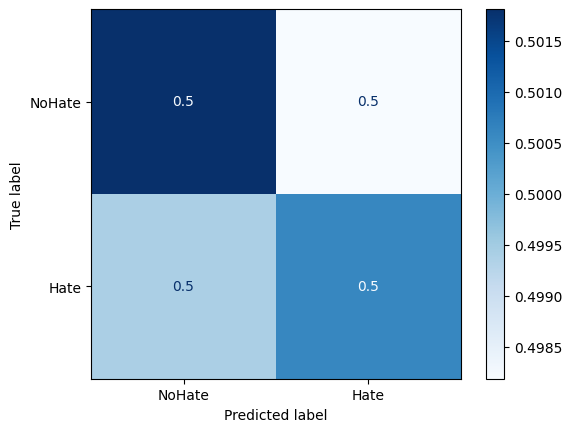

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        Y_test,
        display_labels=["NoHate","Hate"],
        cmap=plt.cm.Blues,
        normalize="true",
    )

print(disp.confusion_matrix)
plt.show()

In [15]:
import pandas as pd
model_name = "dbmdz_bert-base-italian-uncased"
dataset = pd.read_csv(f"{model_name.replace('/','_')}_embeddings.csv",header=None)
import matplotlib.pyplot as plt


#apply pca to reduce the dimensionality of the embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dataset)
dataset = pca.transform(dataset)

a = 1
plt.figure(figsize=(10,10))
for i in range(len(dataset)):
  plt.scatter(dataset[i,0],dataset[i,1])
  plt.annotate(y_ref[i],(dataset[i,0],dataset[i,1]))
plt.title('2D PCA projection of embedded sentences from BERT')

KeyboardInterrupt: 